In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client
from pint import UnitRegistry

units = UnitRegistry()
units.define('gram N = mol / 14.007 = gN')

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

cftime        1.0.3.4
cmocean       2.0
esmlab        2019.4.27.post55
intake_esm    2020.3.16.2.post4
ncar_jobqueue 2020.3.4
xarray        0.15.0
numpy         1.18.1
cartopy       0.17.0
intake        0.5.4
Mike Levy 2020-04-01 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper21
Git hash   : 7801d2039f61623e6915aa8a3b25042611702b06


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.30:46447 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
cluster.scale(4)

In [4]:
def _read_var(dq, time_slice, variable):
    # Define datasets
    dataset = dq['ocn.historical.pop.h']

    keep_vars = ['REGION_MASK', 'z_t', 'z_t_150m', 'dz', 'TAREA', 'TLONG', 'TLAT', 'time', 'time_bound', 'member_id', 'ctrl_member_id'] + [variable]
    dataset = dataset.drop([v for v in dataset.variables if v not in keep_vars]).sel(time=time_slice).mean(dim=['member_id', 'time'])

    return(dataset)

In [5]:
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')

datasets = dict()
for variable in ['diaz_Nfix', 'DENITRIF']:
    dq = catalog.search(experiment='historical', variable=variable).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
    datasets[variable] = _read_var(dq, slice("1990-01-15", "2000-01-15"), variable)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
                
--> There is/are 1 group(s)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
                
--> There is/are 1 group(s)


In [6]:
area_units = units[datasets['diaz_Nfix']['TAREA'].attrs['units']]
vert_units = units[datasets['diaz_Nfix']['dz'].attrs['units']]
vol_units = area_units * vert_units
N_units = dict()
for var in ['diaz_Nfix', 'DENITRIF']:
    N_units[var] = units[datasets[var][var].attrs['units']]

total_integral_units = 'TgN/year'
plot_units = 'mol/m^2/year'

### Vertical integrals first (for plotting)

In [7]:
vwghts = dict()
vdim = dict()
vwghts['diaz_Nfix'] = datasets['diaz_Nfix']['dz'].isel(z_t=slice(0,15)).rename({'z_t' : 'z_t_150m'})
vdim['diaz_Nfix'] = 'z_t_150m'
vwghts['DENITRIF'] = datasets['DENITRIF']['dz']
vdim['DENITRIF'] = 'z_t'

vertical_ints = dict()
val_to_plot = dict()
for var in ['diaz_Nfix', 'DENITRIF']:
    vertical_ints[var] = esmlab.weighted_sum(datasets[var][var], dim=vdim[var], weights=vwghts[var]).to_dataset(name=var)[var].compute()
    # Use below to include marginal seas
#     vertical_ints[var] = vertical_ints[var].where(datasets[var]['REGION_MASK'] != 0).compute()
    # Use below to restrict to open ocean
    vertical_ints[var] = vertical_ints[var].where(datasets[var]['REGION_MASK']>0).compute()
    val_to_plot[var] = (vertical_ints[var].data * N_units[var] * vert_units).to(plot_units)


### Then horizontal integral to get total value for caption

In [8]:
glb_avg = dict()
for var in ['diaz_Nfix', 'DENITRIF']:
    glb_avg_tmp = esmlab.weighted_sum(vertical_ints[var], dim=['nlat', 'nlon'], weights=datasets[var]['TAREA']).to_dataset(name=var)[var].compute()
    glb_avg[var] = (glb_avg_tmp.data * N_units[var] * vol_units).to(total_integral_units)
    print(f'Total {var}: {glb_avg[var]}')

Total diaz_Nfix: 241.3309098515809 teragram N / year
Total DENITRIF: 193.2087200549292 teragram N / year


In [9]:
def plot_single_var(var):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(vertical_ints[var].TLONG,
                       vertical_ints[var].TLAT,
                       val_to_plot[var].magnitude,
                       cmap=cmocean.cm.matter,
                       transform=ccrs.PlateCarree())

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title('Vertical integral of {}\n({} {} total)'.format(var, np.round(glb_avg[var].magnitude, 1), glb_avg[var].units));
    cb.set_label('$\mathrm{' + plot_units + '}$')

# Stats to help determine contour levels
for var in ['diaz_Nfix', 'DENITRIF']:
    print(f'Min and max of {var} ({plot_units}): {np.nanmin(val_to_plot[var].magnitude)}, {np.nanmax(val_to_plot[var].magnitude)}')

Min and max of diaz_Nfix (mol/m^2/year): 0.0, 0.1711055189371109
Min and max of DENITRIF (mol/m^2/year): 0.0, 3.892259120941162


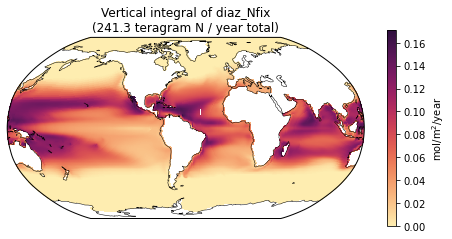

In [10]:
plot_single_var('diaz_Nfix')

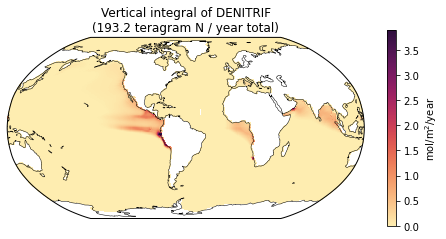

In [11]:
plot_single_var('DENITRIF')